In [430]:
import math

import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

import warnings

warnings.filterwarnings("ignore")

Below will be the shape, head, statistics, and variable information of the pandas formatted csv of the S&P500.

Within this project, the analysis of the S&P500 from 2022 to the end of the 2023 year will be conducted. We will be training various machine learning algorithms to see which is the most successful.

In [431]:
sp500 = yf.download('^GSPC',start='2012-01-01',end='2023-12-31')

[*********************100%%**********************]  1 of 1 completed


In [432]:
print("Dimensions: ")
print(sp500.shape)
print("Data: ")
print(sp500.head())
print("Description: ")
print(sp500.describe())

Dimensions: 
(3018, 6)
Data: 
                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2012-01-03  1258.859985  1284.619995  1258.859985  1277.060059  1277.060059   
2012-01-04  1277.030029  1278.729980  1268.099976  1277.300049  1277.300049   
2012-01-05  1277.300049  1283.050049  1265.260010  1281.060059  1281.060059   
2012-01-06  1280.930054  1281.839966  1273.339966  1277.810059  1277.810059   
2012-01-09  1277.829956  1281.989990  1274.550049  1280.699951  1280.699951   

                Volume  
Date                    
2012-01-03  3943710000  
2012-01-04  3592580000  
2012-01-05  4315950000  
2012-01-06  3656830000  
2012-01-09  3371600000  
Description: 
              Open         High          Low        Close    Adj Close  \
count  3018.000000  3018.000000  3018.000000  3018.000000  3018.000000   
mean   2756.822295  2771.591233  2741.093989  2757.414798  2757.414798   
std  

We can see here that when looking at our first few lines and the description that Close and Adj Close seem to be the same columns, so we can go ahead and clean our data by deleting Adj Close

In [433]:
sp500.drop(['Adj Close'], axis=1, inplace=True)

Next we will plot the S&P500's close price over this two-year period to analyze its growth.

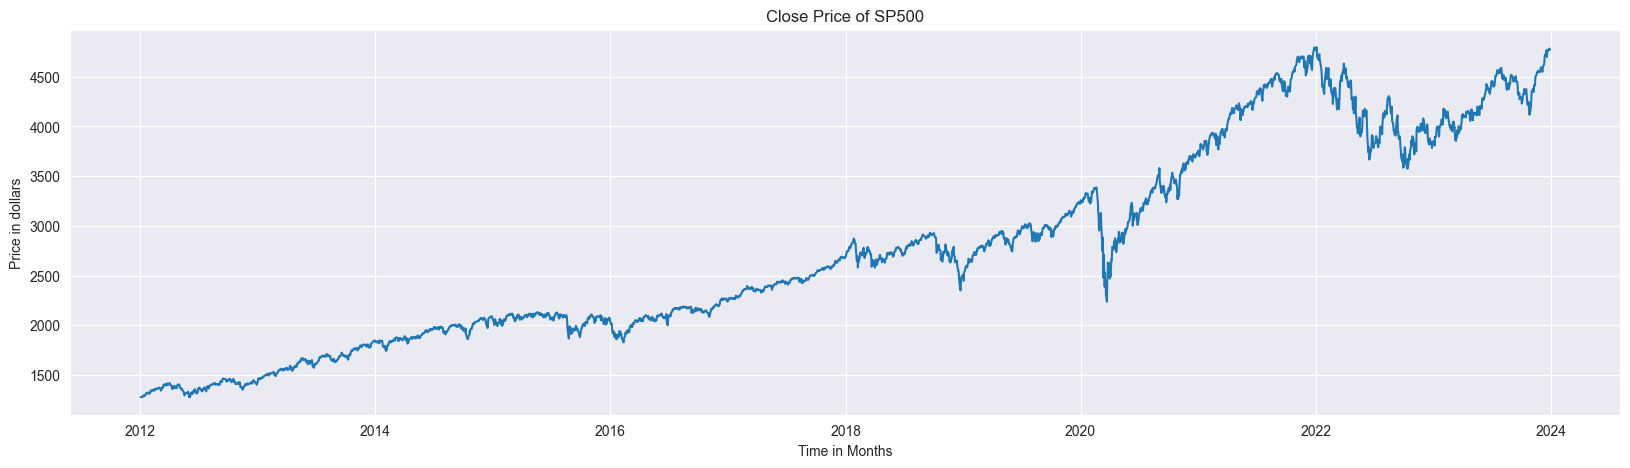

In [434]:
plt.figure(figsize=(20,5))
plt.plot(sp500['Close'])
plt.title('Close Price of SP500')
plt.ylabel('Price in dollars')
plt.xlabel('Time in Months')
plt.show()

From here we can see that the SP500 close price has steadily increased with a few dips around 2020 and 2023. The index peaked around 2022.

In [435]:
closePricesDiff = sp500['Close'].diff().dropna()
trainSize = int(len(closePricesDiff)*.85)
trainData,testData= closePricesDiff[:trainSize],closePricesDiff[trainSize:]

Using the generated Arima Order, we can now train our model to run predictions on our test set.

In [436]:
arima_model = auto_arima(trainData, seasonal=True, suppress_warnings=True)
optimal_order = arima_model.order
optimal_seasonal_order = arima_model.seasonal_order
print(arima_model.summary())
arima_model = ARIMA(trainData, order=optimal_order, seasonal_order=optimal_seasonal_order)
arima_model=arima_model.fit()
predictions = arima_model.predict(start=trainSize, end=len(closePricesDiff) - 1, typ='levels')
predicted_close_prices = sp500['Close'][trainSize:].iloc[0] + np.cumsum(predictions)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2564
Model:               SARIMAX(2, 0, 2)   Log Likelihood              -12120.579
Date:                Sat, 03 Feb 2024   AIC                          24253.159
Time:                        20:18:44   BIC                          24288.255
Sample:                             0   HQIC                         24265.884
                               - 2564                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.1352      1.944      2.127      0.033       0.324       7.946
ar.L1         -1.7394      0.011   -151.306      0.000      -1.762      -1.717
ar.L2         -0.8837      0.011    -81.875      0.0

Now we will evaluate the model using a mean squared error test.

In [437]:
rmse = math.sqrt(mean_squared_error(testData, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 48.848


Finally, we will plot the predicted close price vs. the actual close price using this model. 

454 453


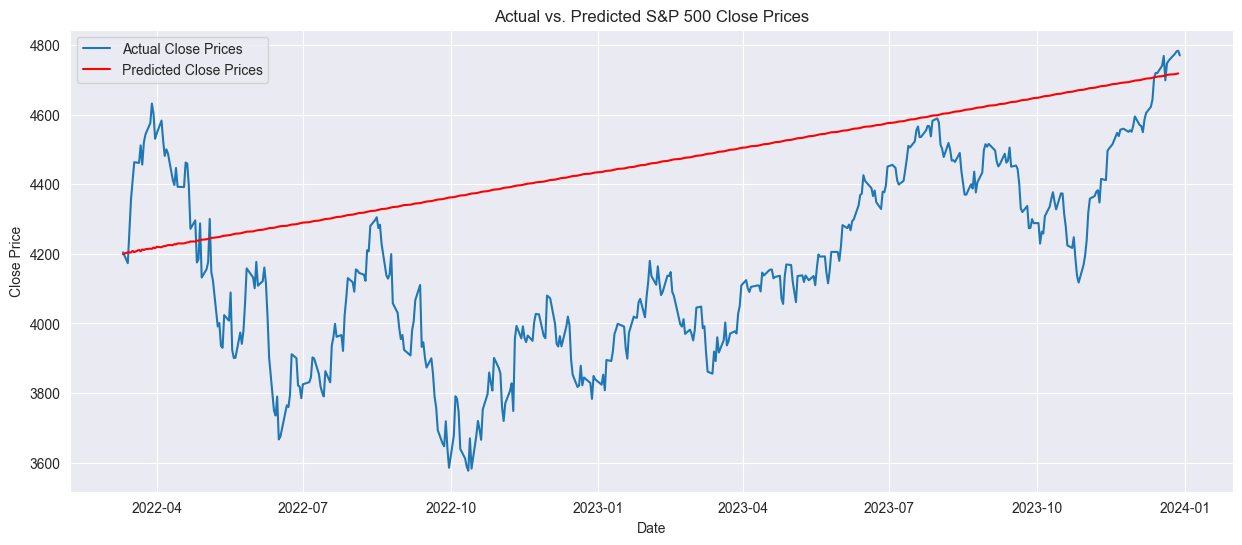

In [438]:
actual_dates = sp500['Close'].index[trainSize:]
predicted_dates = sp500['Close'].index[trainSize:trainSize + len(predictions)]
plt.figure(figsize=(15, 6))
print(len(actual_dates), len(predicted_dates))
plt.plot(actual_dates, sp500['Close'][trainSize:], label='Actual Close Prices')
plt.plot(predicted_dates, predicted_close_prices, color='red', label='Predicted Close Prices')
plt.title('Actual vs. Predicted S&P 500 Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()